<a href="https://colab.research.google.com/github/frank-morales2020/MLxDL/blob/main/FTDEMO_LLAMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install colab-env -q
!pip install datasets -q
!pip install transformers -q
!pip install evaluate -q
!pip install bitsandbytes -q
!pip install accelerate -q

In [ ]:
import random
from datasets import Dataset
from geopy.geocoders import Nominatim
from geopy.distance import geodesic
from tqdm import tqdm  # Import tqdm for the progress bar


# Define necessary lists
airports = ["JFK", "LAX", "LGA", "BOS", "SFO", "ORD", "DFW", "ATL", "SEA", "MIA", "DEN", "IAH", "MSP", "DTW", "PHX", "CLT", "LAS", "MCO", "EWR", "PHL"]
aircraft_types = ["Boeing 747", "Airbus A320", "Boeing 777", "Boeing 737", "Airbus A330", "Boeing 757", "Airbus A321", "Airbus A319", "Boeing 787", "Embraer E190"]
weather_conditions = ["Clear", "Cloudy", "Rainy", "Snowy", "Windy"]

# Initialize geolocator
geolocator = Nominatim(user_agent="flight_planner", timeout=10)

def create_flight_data_point(origin, destination, departure_date, aircraft, weather):
    """Creates a flight data point with distance category as the label."""
    try:
        location_origin = geolocator.geocode(origin)
        location_destination = geolocator.geocode(destination)

        if location_origin and location_destination:
            # Calculate distance using geodesic
            distance = geodesic(
                (location_origin.latitude, location_origin.longitude),
                (location_destination.latitude, location_destination.longitude)
            ).kilometers

            # Categorize distance
            if distance < 500:
                distance_category = "short"
            elif distance < 1500:
                distance_category = "medium"
            else:
                distance_category = "long"

            # Modified input text:
            return {
                "input": f"Calculate the distance from {origin} to {destination}. Departure: {departure_date}, Aircraft: {aircraft}, Weather: {weather}",
                "label": distance_category  # Store distance category as the label
            }
        else:
            print(f"Could not find coordinates for {origin} or {destination}")
            return None

    except Exception as e:
        print(f"Error generating flight data point: {e}")
        return None

# --- Dataset Creation Loop ---
flight_data = []
number_routes = 10000  # You can adjust this number

# Wrap the loop with tqdm to create a progress bar
for _ in tqdm(range(number_routes), desc="Generating flight data"):
    origin = random.choice(airports)
    destination = random.choice(airports)
    while origin == destination:
        destination = random.choice(airports)
    departure_date = f"2024-{random.randint(1, 12):02}-{random.randint(1, 28):02}"
    aircraft = random.choice(aircraft_types)
    weather = random.choice(weather_conditions)

    data_point = create_flight_data_point(origin, destination, departure_date, aircraft, weather)
    if data_point:
        flight_data.append(data_point)

# --- Create the Dataset ---
dataset = Dataset.from_list(flight_data)
print(dataset)
## 127/10000

In [ ]:
from datasets import load_from_disk
import colab_env

#Prepare the Dataset
dataset = load_from_disk("/content/gdrive/MyDrive/datasets/flight_dataset_tpu")
print(dataset)  # Inspect the dataset

In [8]:
dataset

Dataset({
    features: ['input', 'label'],
    num_rows: 1127
})

In [5]:
dataset[100]

{'input': 'Calculate the distance from ORD to DTW. Departure: 2024-07-10, Aircraft: Airbus A330, Weather: Cloudy',
 'label': 'short'}

In [6]:
dataset[0]

{'input': 'Calculate the distance from DFW to ORD. Departure: 2024-03-25, Aircraft: Airbus A321, Weather: Snowy',
 'label': 'medium'}

In [7]:
dataset[200]

{'input': 'Calculate the distance from DFW to JFK. Departure: 2024-12-18, Aircraft: Airbus A321, Weather: Rainy',
 'label': 'long'}

In [10]:
from transformers import AutoTokenizer, AutoModelForCausalLM, TrainingArguments, Trainer, BitsAndBytesConfig
import torch
import bitsandbytes as bnb
import evaluate # Import the evaluate library
from peft import LoraConfig, get_peft_model # Import PEFT modules
import warnings
warnings.filterwarnings("ignore")


# Model and Tokenizer
model_name = "meta-llama/Llama-2-7b-chat-hf"
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token

# Quantization Config
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
)

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map="auto"
)

# PEFT Configuration (LoRA)
peft_config = LoraConfig(
    r=8,
    lora_alpha=32,
    target_modules=["q_proj", "v_proj"],
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM"
)

model = get_peft_model(model, peft_config)
model.print_trainable_parameters()

# Label Mapping
label_mapping = {
    "short": 0,
    "medium": 1,
    "long": 2
}

# Tokenize and Format
def tokenize_function(examples):
    examples["labels"] = [label_mapping[label] for label in examples["label"]]
    # Specify a fixed max_length for padding
    tokenized_output = tokenizer(
        examples["input"],
        padding="max_length",
        truncation=True,
        max_length=128  # Set a fixed max_length here
    )
    # Instead of assigning labels directly, shift them for causal LM
    tokenized_output['labels'] = tokenized_output['input_ids'].copy()
    # Replace input_ids corresponding to pad_token with -100 in labels
    tokenized_output['labels'] = [
        [-100 if token == tokenizer.pad_token_id else token for token in label_list]
        for label_list in tokenized_output['labels']
    ]
    return tokenized_output

tokenized_datasets = dataset.map(tokenize_function, batched=True)
print('\n')
print(tokenized_datasets) # Inspect after tokenization
print('\n')

# Remove unnecessary columns
tokenized_datasets = tokenized_datasets.remove_columns(["input", "label"])
tokenized_datasets.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

# Split Dataset
train_testvalid = tokenized_datasets.train_test_split(test_size=0.2, seed=42)
train_dataset = train_testvalid["train"]
testvalid_dataset = train_testvalid["test"]
test_valid = testvalid_dataset.train_test_split(test_size=0.5, seed=42)
eval_dataset = test_valid["test"]
test_dataset = test_valid["train"]

small_train_dataset = train_dataset.shuffle(seed=42).select(range(800))
small_eval_dataset = eval_dataset.shuffle(seed=42).select(range(113))

# Metric
metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    # Get predictions for the last non-padded token for each sequence
    predictions = logits[:, :-1, :].argmax(-1)  # Exclude last token (usually pad)
    # Remove -100 from labels before computing accuracy
    labels_cleaned = labels[:, 1:]  # Exclude the first token to align
    labels_cleaned = labels_cleaned[labels_cleaned != -100]
    predictions_cleaned = predictions.flatten()[labels[:, 1:].flatten() != -100]

    return metric.compute(predictions=predictions_cleaned, references=labels_cleaned)

# Training Arguments
training_args = TrainingArguments(
    output_dir="./results",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=5,
    evaluation_strategy="steps",
    save_strategy="steps",
    load_best_model_at_end=True,
    learning_rate=2e-5,
    weight_decay=0.01,
    push_to_hub=False,
    report_to='none',
    logging_steps=10,
)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=small_train_dataset,
    eval_dataset=small_eval_dataset,
    compute_metrics=compute_metrics,
)

# Train
trainer.train()

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

trainable params: 4,194,304 || all params: 6,742,609,920 || trainable%: 0.0622


Dataset({
    features: ['input', 'label', 'labels', 'input_ids', 'attention_mask'],
    num_rows: 1127
})




No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss,Validation Loss,Accuracy
10,2.647500,2.563680,0.477778
20,2.368800,2.242467,0.498077
30,2.015200,1.871687,0.596154
40,1.678200,1.540268,0.650000
50,1.394200,1.291684,0.728419
60,1.187500,1.139719,0.760897
70,1.052200,1.034527,0.766239
80,0.992300,1.000433,0.773291
90,0.972900,0.976791,0.773077
100,0.950400,0.958290,0.777564


TrainOutput(global_step=500, training_loss=0.6609676523208619, metrics={'train_runtime': 2992.0475, 'train_samples_per_second': 1.337, 'train_steps_per_second': 0.167, 'total_flos': 2.031064449024e+16, 'train_loss': 0.6609676523208619, 'epoch': 5.0})

In [11]:
# Data from the table
steps = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380, 390, 400, 410, 420, 430, 440, 450, 460, 470, 480, 490, 500]
training_loss = [2.647500, 2.368800, 2.015200, 1.678200, 1.394200, 1.187500, 1.052200, 0.992300, 0.972900, 0.950400, 0.928700, 0.903700, 0.857000, 0.788400, 0.705900, 0.618700, 0.513600, 0.395200, 0.387300, 0.383900, 0.380900, 0.381700, 0.379600, 0.381500, 0.379600, 0.381200, 0.382000, 0.379000, 0.378000, 0.379500, 0.376500, 0.375300, 0.379300, 0.377400, 0.375000, 0.373100, 0.375800, 0.376100, 0.375800, 0.376500, 0.373600, 0.373000, 0.373700, 0.374100, 0.376200, 0.373700, 0.377300, 0.374800, 0.373100, 0.373600]
validation_loss = [2.563680, 2.242467, 1.871687, 1.540268, 1.291684, 1.139719, 1.034527, 1.000433, 0.976791, 0.958290, 0.934269, 0.902291, 0.842760, 0.765889, 0.673689, 0.579012, 0.424397, 0.396611, 0.395504, 0.392481, 0.390506, 0.390823, 0.393844, 0.389384, 0.391058, 0.389366, 0.389191, 0.390625, 0.389741, 0.388816, 0.390726, 0.391737, 0.389069, 0.387597, 0.386585, 0.385939, 0.385927, 0.386165, 0.386341, 0.386573, 0.386550, 0.386633, 0.386719, 0.386704, 0.386352, 0.385689, 0.385488, 0.385464, 0.385497, 0.385498]
accuracy = [0.477778, 0.498077, 0.596154, 0.650000, 0.728419, 0.760897, 0.766239, 0.773291, 0.773077, 0.777564, 0.777350, 0.779915, 0.780556, 0.777991, 0.804487, 0.804915, 0.828846, 0.826282, 0.826282, 0.828846, 0.829701, 0.830983, 0.830128, 0.827778, 0.827137, 0.828205, 0.829060, 0.827991, 0.828632, 0.825427, 0.827137, 0.827564, 0.827350, 0.827564, 0.827564, 0.830556, 0.829274, 0.829915, 0.830769, 0.829060, 0.829274, 0.830769, 0.829487, 0.828846, 0.828419, 0.828419, 0.826923, 0.828419, 0.828846, 0.829701]


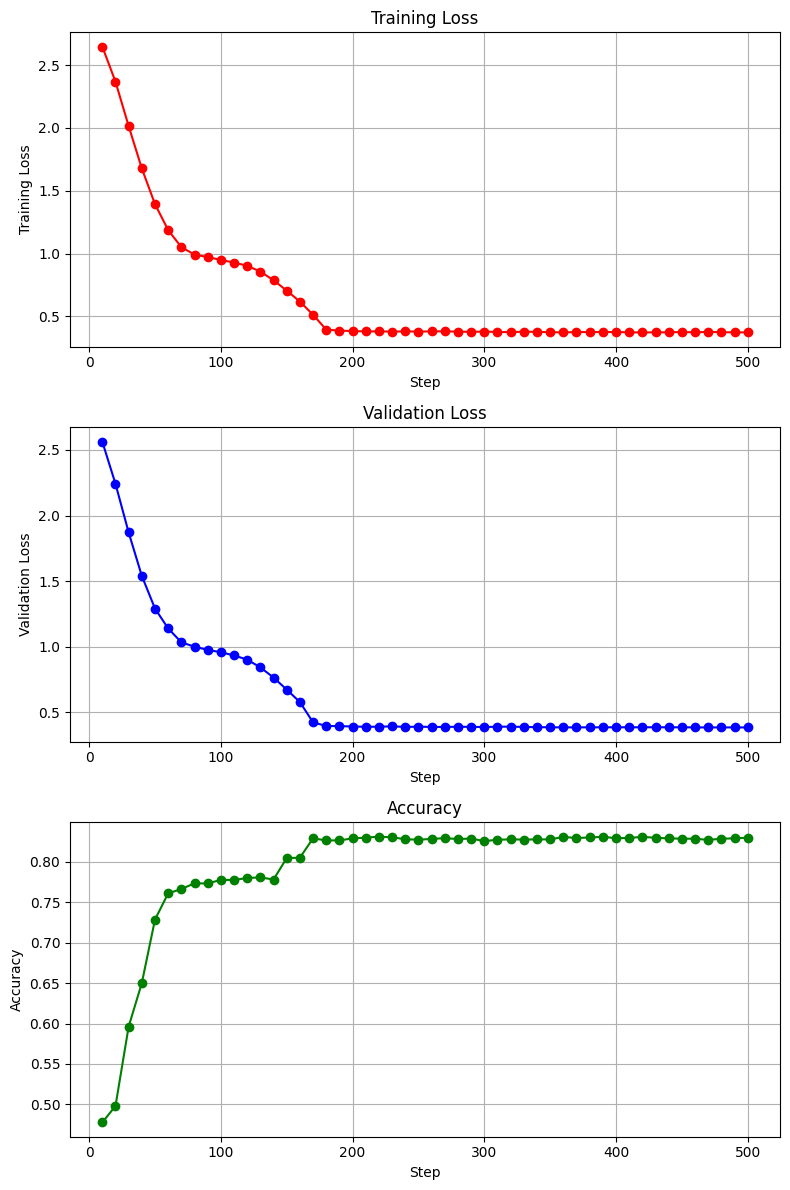

In [12]:
import matplotlib.pyplot as plt


# Create subplots
fig, axs = plt.subplots(3, 1, figsize=(8, 12))

# Plot Training Loss
axs[0].plot(steps, training_loss, marker='o', color='red')
axs[0].set_title('Training Loss')
axs[0].set_xlabel('Step')
axs[0].set_ylabel('Training Loss')
axs[0].grid(True)

# Plot Validation Loss
axs[1].plot(steps, validation_loss, marker='o', color='blue')
axs[1].set_title('Validation Loss')
axs[1].set_xlabel('Step')
axs[1].set_ylabel('Validation Loss')
axs[1].grid(True)

# Plot Accuracy
axs[2].plot(steps, accuracy, marker='o', color='green')
axs[2].set_title('Accuracy')
axs[2].set_xlabel('Step')
axs[2].set_ylabel('Accuracy')
axs[2].grid(True)

plt.tight_layout()
plt.show()